In [74]:
def makeTransparent(mask, alpha=.6):
    src = mask
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, int(255*alpha), cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)
    return dst
    
def blend_transparent(face_img, overlay_t_img):
	# Split out the transparency mask from the colour info
	overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
	overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

	# Again calculate the inverse mask
	background_mask = 255 - overlay_mask

	# Turn the masks into three channel, so we can use them as weights
	overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
	background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

	# Create a masked out face image, and masked out overlay
	# We convert the images to floating point in range 0.0 - 1.0
	face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
	overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

	# And finally just add them together, and rescale it back to an 8bit integer image
	return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

def flatten(arrs):
	# Flatten blobs into single matrix for viewing
	x = np.zeros((arrs.shape[0], arrs.shape[1]), dtype=np.int)
	for i in range(arrs.shape[2]):
		x[:,:]+= arrs[:,:,i]
	return x

# ==============================================================================

In [98]:
def slide(image, greyImage, model):
	out= np.zeros(greyImage.shape)

	# Define sliding window shifts
	size = image.shape
	remX= (size[1]-CROP_SIZE) % STEP_SIZE_X
	remY= (size[0]-CROP_SIZE) % STEP_SIZE_Y
	numX= int((size[1]-remX) / STEP_SIZE_X)
	numY = int((size[0]-remY) / STEP_SIZE_Y)

	# Start sliding
	xPos= 0
	yPos= 0
	for i in range(1+numX):
		if i != 0:
			if i == numX:
				if remX != 0:
					xPos += remX
				else:
					break
			else:
				xPos += STEP_SIZE_X
		yPos=0
		for j in range(1+numY):
			if j!=0:
				if j==numY:
					if remY!=0:
						yPos+= remY
					else:
						break
				else:
					yPos+= STEP_SIZE_Y
			out= detect(out, greyImage, xPos=xPos, yPos=yPos)
            
	return out
            
            
def detect(out, greyImage, xPos=0, yPos=0):
    # Run bubble detection
    results= model.detect([image[yPos:yPos+CROP_SIZE, xPos:xPos+CROP_SIZE]], verbose=0)
    
    print(results[0]['scores'])
    print(f'{len(results[0]["scores"])} masks found')
          
    # Remove low-scoring masks
    r= filterResults(results[0], .98)
          
    print(f'{len(r["scores"])} masks after filter')
    
    # Floodfill bubbles
    for i in range(len(r['scores'])):
        fl= floodfill(greyImage, r['masks'][:,:,i], xPos=xPos, yPos=yPos)      
        out= np.logical_or(out, fl)
    
    vis= 255*out[yPos:yPos+CROP_SIZE, xPos:xPos+CROP_SIZE]
#     visualize.display_instances(np.dstack((vis,vis,vis)), r['rois'], r['masks'], r['class_ids'], 
#                 ['BG', 'bubble'], r['scores'],
#                 title="Predictions")
          
#     visualize.display_instances(image[yPos:yPos+CROP_SIZE, xPos:xPos+CROP_SIZE], r['rois'], r['masks'], r['class_ids'], 
#                 ['BG', 'bubble'], r['scores'],
#                 title="Predictions")
    
    try:      
        print(np.amax(r['masks']))
        msk= flatten(r['masks'])
        if np.amax(msk) < 255:
            msk=(msk*174).astype(np.uint8)
        if len(msk.shape) == 2:
            msk= np.dstack((np.zeros(msk.shape), np.zeros(msk.shape),msk)).astype(np.uint8)
        msk= makeTransparent(msk,alpha=.3)

        fld= out[yPos:yPos+CROP_SIZE, xPos:xPos+CROP_SIZE]
        fld= np.multiply(fld,174)
        fld= np.dstack((fld,np.zeros(fld.shape), np.zeros(fld.shape)))
        fld= makeTransparent(fld.astype(np.uint8),alpha=.3)

        result= blend_transparent(image[yPos:yPos+CROP_SIZE, xPos:xPos+CROP_SIZE],msk)
        result= blend_transparent(result,fld)

        from datetime import datetime
        datetime.now().strftime('%m-%d-%H-%M-%S')

        png.from_array(np.uint8(result), mode="RGB").save(("C:/Users/Pray/Desktop/demo/rand/" + str(datetime.now().strftime('%m-%d-%H-%M-%S'))) + ".png")
    except Exception as e:
        True
    return out


def floodfill(greyImage, mask, xPos=0, yPos=0):
    im= np.zeros(greyImage.shape)
          
    # Select parts of greyscale image that overlap with mask
    region= greyImage[yPos:yPos+mask.shape[0], xPos:xPos+mask.shape[1]]
    temp= np.logical_and(greyImage[yPos:yPos+mask.shape[0], xPos:xPos+mask.shape[1]], mask)
    
    # Separate into blobs
    arrsW = blobify(temp, *componentify(temp))
    arrsB = blobify(1-temp, *componentify(1-temp))
    
    #TODO: this
    if arrsW.shape[2] <= 1 and arrsB.shape[2] <= 1:
        print("Not enough blobs detected.")
        #return im
    
    #Pick largest (white) blob
    maxInd = 0
    if arrsW.shape[2] > 1:
        print('Warning: More than one white background detected')

        sizes = []
        for i in range(arrsW.shape[2]):
            sizes.append(np.count_nonzero(arrsW[:, :, i]))
        print(f'Sizes: {sizes}')

        maxInd = np.argmax(sizes)
        print(f'Max at {maxInd}')

    
    # Get first non-zero value
    wh= np.where(arrsW[:,:,maxInd])
    if not len(wh[0]) or not len(wh[1]):
        print("No coordinates found.")
        return im
    row= wh[0][0]
    col= wh[1][0]
    
    # Expand previously selected blob and fill holes
    fill2= flood(region, (row,col))#ndimage.binary_fill_holes(im).astype(np.uint8)
    fill= ndimage.binary_fill_holes(fill2).astype(np.uint8)
    
    # Return to original canvas size
    im[yPos:yPos+mask.shape[0], xPos:xPos+mask.shape[1]]= fill
    return im

In [1]:
import cv2, os, sys, png
import numpy as np
from scipy.ndimage import label
from skimage.segmentation import flood, flood_fill
import glob, os

ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config


def readRGB(imPath):
	image = cv2.imread(imPath, 1)
	temp = np.copy(image)
	temp[:, :, 0] = image[:, :, 2]
	temp[:, :, 2] = image[:, :, 0]
	return np.array(temp)

def filterResults(r, minScore):
	inds= []
	for i in reversed(range(len(r['scores']))):
		if r['scores'][i] > minScore:
			break
		else:
			inds.append(i)
	r['masks']= np.delete(r['masks'], inds, 2)
	r['scores']= np.delete(r['scores'], inds, 0)
	r['class_ids']= np.delete(r['class_ids'], inds, 0)
	r['rois']= np.delete(r['rois'], inds, 0)

	return r

def componentify(result):
	# Identify connected components
	structure = np.ones((3, 3), dtype=np.int)
	labeled, ncomponents = label(result, structure)

	# Remove blobs with area < 25
	whitelist = []
	unique, counts = np.unique(labeled, return_counts=True)
	# print(unique, counts)
	for i, j in zip(unique[1:], counts[1:]):
		if j > 25:
			# print(i,j)
			whitelist.append(i)

	return labeled, whitelist

def blobify(result, labeled, whitelist):
	# Separate blobs
	ind = 0
	seen = {}
	arrs = np.zeros((result.shape[0], result.shape[1], len(whitelist)), dtype=np.int)
	for i in range(result.shape[0]):
		for j in range(result.shape[1]):
			if labeled[i, j] not in whitelist:
				continue
			if labeled[i, j] != 0:
				if i % 50 == 0 and j % 50 == 0:
					True  # print(f'i{i} j{j} is {result[i,j]} with label {labeled[i,j]}')
				if result[i, j] == 1:
					string = str(labeled[i, j] - 1)
					if string not in seen:
						seen.update({string: ind})
						ind += 1
					arrs[i, j, seen[str(labeled[i, j] - 1)]] = 255
				else:
					print('wowwee', result[i, j])

	if len(whitelist) == 0:
		arrs = np.zeros((result.shape[0], result.shape[1], 1), dtype=np.int)

	return arrs

def flatten(arrs):
	# Flatten blobs into single matrix for viewing
	x = np.zeros((arrs.shape[0], arrs.shape[1]), dtype=np.int)
	for i in range(arrs.shape[2]):
		x[:,:]+= arrs[:,:,i]
	return x

class BubbleConfig(Config):
	"""Configuration for training on the toy  dataset.
	Derives from the base Config class and overrides some values.
	"""
	BACKBONE = "resnet50"

	# Give the configuration a recognizable name
	NAME = "bubble"

	# We use a GPU with 12GB memory, which can fit two images.
	# Adjust down if you use a smaller GPU.
	IMAGES_PER_GPU = 1

	# Number of classes (including background)
	NUM_CLASSES = 1 + 1  # Background + balloon

	# Number of training steps per epoch
	STEPS_PER_EPOCH = 500

	# Skip detections with < 90% confidence
	# DETECTION_MIN_CONFIDENCE = 0.9

	IMAGE_RESIZE_MODE = 'crop'
	IMAGE_MIN_DIM = 512

	MAX_GT_INSTANCES = 40

In [28]:
import os

import cv2
from scipy import ndimage

from mrcnn import model as modellib, utils, visualize

# Load CNN
model_dir= "C:/Programming/BaboBot2/Mask_RCNN-master/logs"
model= modellib.MaskRCNN(mode="inference", model_dir=model_dir, config=BubbleConfig())

model_path = model.find_last()
model.load_weights(model_path, by_name=True)

# Sliding window parameters
margin=80
CROP_SIZE= 512
STEP_SIZE_X= CROP_SIZE-margin
STEP_SIZE_Y= CROP_SIZE-margin


Re-starting from epoch 108


In [ ]:
DIR= "C:/Users/Pray/Desktop/dataset1/val/images/"
OUT_DIR= "C:/Users/Pray/Desktop/demo/test/masks/"
for imPath in glob.glob(f"{DIR}*.png"):
    print(imPath)
    # Load image
    image= readRGB(imPath)
    greyImage= cv2.imread(f"{imPath}", 0)

    # Level image
    __, greyImage= cv2.threshold(greyImage, 240, 1, cv2.THRESH_BINARY)

    # rdy set go
    out= slide(image, greyImage, model)
    
    filePath= os.path.join(OUT_DIR, os.path.basename(imPath))
    png.from_array(np.uint8(out*255), mode="L").save(f'{filePath}')

C:/Users/Pray/Desktop/dataset1/val/images\172-1.png
[0.9998005  0.9985293  0.996414   0.99234515 0.90086055]
5 masks found
4 masks after filter
True
[0.9998276  0.99791735 0.99101233 0.7361871 ]
4 masks found
3 masks after filter
Not enough blobs detected.
True
[0.9991837  0.99794966 0.9833196  0.94156426 0.90463364]
5 masks found
3 masks after filter
Sizes: [3962, 37]
Max at 0
True
[0.9996474 0.9994616 0.9984572 0.9953625]
4 masks found
4 masks after filter
True
[0.9999373 0.9998869 0.9997111]
3 masks found
3 masks after filter
True
[0.99961996 0.9991761  0.9973149  0.9965699  0.9918624 ]
5 masks found
5 masks after filter
True
[0.9963786  0.98902076 0.98747313 0.7581427 ]
4 masks found
3 masks after filter
Not enough blobs detected.
Sizes: [5910, 28]
Max at 0
True
[0.9998512  0.99919313 0.99437404 0.98665446 0.90073586 0.8533159 ]
6 masks found
4 masks after filter
Sizes: [6484, 42]
Max at 0
True
[0.99982303 0.99914837 0.99881685 0.9965198 ]
4 masks found
4 masks after filter
True
[0

Not enough blobs detected.
True
[0.99976367 0.9997528  0.9995092  0.9804114  0.93127817 0.781026  ]
6 masks found
4 masks after filter
Not enough blobs detected.
No coordinates found.
True
[0.73298824 0.712973  ]
2 masks found
0 masks after filter
[0.99989295 0.9997168  0.99955183 0.9563354  0.81910145]
5 masks found
3 masks after filter
True
[0.9995223  0.99911004 0.9923395  0.9873976  0.9650656  0.9397117
 0.92518437 0.73048997]
8 masks found
4 masks after filter
Not enough blobs detected.
Sizes: [7492, 829, 11182]
Max at 2
True
[0.9999672  0.99994254 0.9997689  0.99966586 0.99873704 0.9968309
 0.98951083 0.8026889 ]
8 masks found
7 masks after filter
True
[0.99950206 0.9993851  0.9989767  0.89670557]
4 masks found
3 masks after filter
True
[0.99901736 0.8035135 ]
2 masks found
1 masks after filter
True
C:/Users/Pray/Desktop/dataset1/val/images\181-7.png
[]
0 masks found
0 masks after filter
[]
0 masks found
0 masks after filter
[]
0 masks found
0 masks after filter
[]
0 masks found


[]
0 masks found
0 masks after filter
C:/Users/Pray/Desktop/dataset1/val/images\190-7.png
[0.99987423 0.99852043]
2 masks found
2 masks after filter
True
[0.8727775]
1 masks found
0 masks after filter
[0.8599494  0.83550256 0.77929235 0.7371276 ]
4 masks found
0 masks after filter
[0.955275  0.9524716 0.9382095 0.809781 ]
4 masks found
0 masks after filter
[0.99941385 0.9992211  0.9798765 ]
3 masks found
2 masks after filter
True
[0.9997168 0.9968196 0.7808852]
3 masks found
2 masks after filter
True
[]
0 masks found
0 masks after filter
[0.99978906 0.9364124 ]
2 masks found
1 masks after filter
True
[0.99981934 0.9705734 ]
2 masks found
1 masks after filter
True
[0.9999443  0.9998462  0.9762056  0.93458754]
4 masks found
2 masks after filter
True
C:/Users/Pray/Desktop/dataset1/val/images\191-7.png
[0.7232956]
1 masks found
0 masks after filter
[0.99965036 0.9279267  0.7504407 ]
3 masks found
1 masks after filter
True
[0.99919134 0.998398   0.8608977 ]
3 masks found
2 masks after filte

In [60]:
cv2.imshow('out', (255*out).astype(np.uint8)) 
cv2.waitKey(0)
cv2.destroyAllWindows()

In [30]:
import glob, os

import png
from scipy.ndimage.measurements import label
import matplotlib.pyplot as plt
import cv2
import numpy as np

DATASET_DIR= "C:/Users/Pray/Desktop/dataset1/val/"
EXTENSION= ".png"
OUT_DIR= "C:/Users/Pray/Desktop/demo/" + "preview/"




def blend_transparent(face_img, overlay_t_img):
	# Split out the transparency mask from the colour info
	overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
	overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

	# Again calculate the inverse mask
	background_mask = 255 - overlay_mask

	# Turn the masks into three channel, so we can use them as weights
	overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
	background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

	# Create a masked out face image, and masked out overlay
	# We convert the images to floating point in range 0.0 - 1.0
	face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
	overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

	# And finally just add them together, and rescale it back to an 8bit integer image
	return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

# ==============================================================================





# Loop thru folders (train / test / val)
for imPath in glob.glob(f"{DATASET_DIR}images/*{EXTENSION}"):
    #file= imPath.replace("images", "masks")
    file= "C:/Users/Pray/Desktop/demo/test/masks/" + os.path.basename(imPath)
    print(imPath, file)

    # Load image
    im= cv2.imread(f"{imPath}", -1)

    # Load mask
    mask = cv2.imread(f"{file}", 0)
    mask[:,:]= np.multiply(np.divide(mask[:,:],255),174)
    mask= np.dstack((np.zeros(mask.shape),np.zeros(mask.shape),mask)).astype(np.uint8)
    
    mask= mask[:,:,0:3]
    im= im[:,:,0:3]

    # Make RGBA version of mask
    src = mask
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, int(255*.6), cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)

    # We load the images
    face_img = im
    overlay_t_img = dst

    #print(file, mask.shape, dst.shape, "\n", imPath, im.shape)
    result_2 = blend_transparent(face_img, overlay_t_img)
    

    # Convert from BGR to RGB
    temp= np.copy(result_2)
    temp[:,:,0]= result_2[:,:,2]
    temp[:,:,2]= result_2[:,:,0]
    result_2= temp
    
#     cv2.imshow('image', result_2)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     continue


    # write blobs to file
    filePath= os.path.join(OUT_DIR, os.path.basename(imPath))
    if not os.path.exists(OUT_DIR):
        print(f"Making {OUT_DIR}")
        os.makedirs(OUT_DIR)
    print(filePath)
    png.from_array(np.uint8(result_2), mode="RGB").save(f'{filePath}')

C:/Users/Pray/Desktop/dataset1/val/images\172-1.png C:/Users/Pray/Desktop/demo/test/masks/172-1.png
C:/Users/Pray/Desktop/demo/preview/172-1.png
C:/Users/Pray/Desktop/dataset1/val/images\173-5.png C:/Users/Pray/Desktop/demo/test/masks/173-5.png
C:/Users/Pray/Desktop/demo/preview/173-5.png
C:/Users/Pray/Desktop/dataset1/val/images\174-14.png C:/Users/Pray/Desktop/demo/test/masks/174-14.png
C:/Users/Pray/Desktop/demo/preview/174-14.png
C:/Users/Pray/Desktop/dataset1/val/images\175-7.png C:/Users/Pray/Desktop/demo/test/masks/175-7.png
C:/Users/Pray/Desktop/demo/preview/175-7.png
C:/Users/Pray/Desktop/dataset1/val/images\176-13.png C:/Users/Pray/Desktop/demo/test/masks/176-13.png
C:/Users/Pray/Desktop/demo/preview/176-13.png
C:/Users/Pray/Desktop/dataset1/val/images\177-15.png C:/Users/Pray/Desktop/demo/test/masks/177-15.png
C:/Users/Pray/Desktop/demo/preview/177-15.png
C:/Users/Pray/Desktop/dataset1/val/images\178-7.png C:/Users/Pray/Desktop/demo/test/masks/178-7.png
C:/Users/Pray/Desktop

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
[0.99911946]
1 masks found


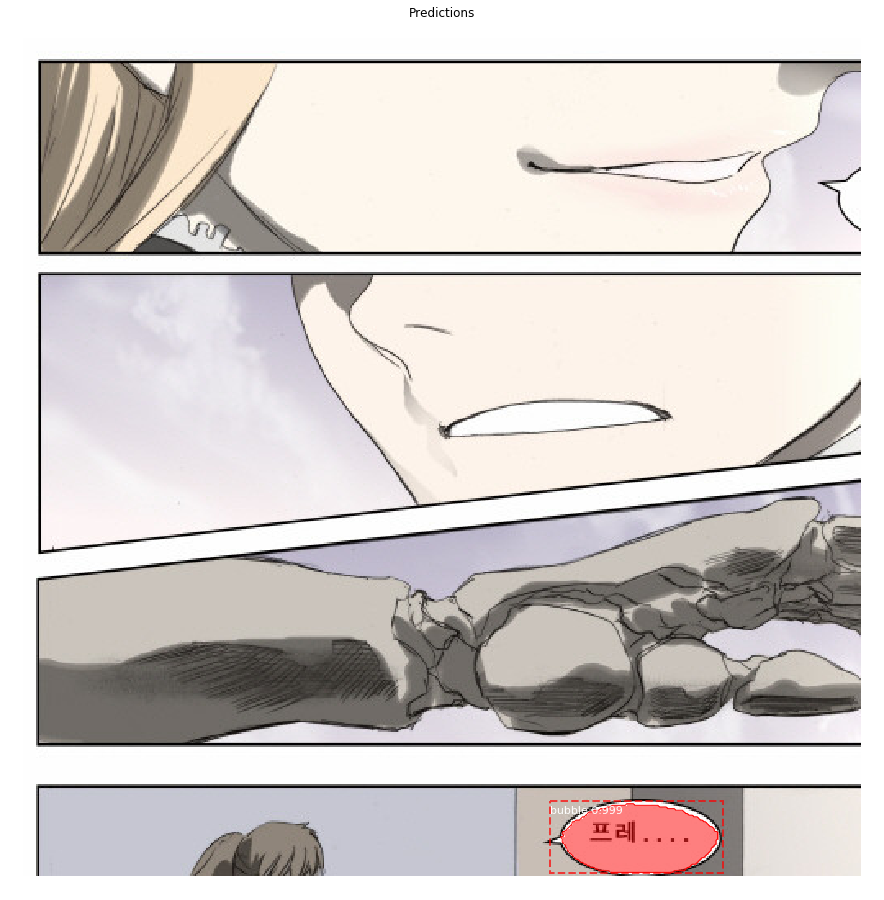

1 masks after filter


In [28]:
out= np.zeros(greyImage.shape)
out= detect(out, greyImage)